In [1]:
import copy
import os
import numpy as np
import matplotlib.pyplot as plt
from pydmd import DMD
from pydmd.bopdmd import BOPDMD
from pydmd import DMDc
from scipy.signal import StateSpace, lsim, dlsim, cont2discrete,butter
from scipy.io import loadmat,savemat
import pysindy as ps
from sklearn.metrics import mean_squared_error
import scipy
from pydmd.plotter import plot_eigs
from sklearn.preprocessing import StandardScaler
from scipy.fft import fft
import pickle
import control as ct

In [2]:
def bopdmd_train_test(svd_rank,num_trials,training_set,training_voltage,test_voltage,train_time,test_time,Btilde,return_training_fit, 
                     conjugate_bool, stable_bool, noise_level, evaluate,C,D):
    optdmd = BOPDMD(svd_rank = svd_rank, compute_A = True) #make our opt and bop objects with the correct
                                                            #number of trials and svd rank
        
        
    if conjugate_bool == True and stable_bool == True:
        bopdmd = BOPDMD(svd_rank = svd_rank, num_trials = num_trials, compute_A = True, eig_constraints = {'stable', 'conjugate_pairs'})
    elif conjugate_bool == True and stable_bool == False:
        bopdmd = BOPDMD(svd_rank = svd_rank, num_trials = num_trials, compute_A = True, eig_constraints = {'conjugate_pairs'})
    elif stable_bool == True and conjugate_bool == False:
        bopdmd = BOPDMD(svd_rank = svd_rank, num_trials = num_trials, compute_A = True, eig_constraints = {'stable'})
    else:
        bopdmd = BOPDMD(svd_rank = svd_rank, num_trials = num_trials, compute_A = True)
    
#     rmse = mean_squared_error(training_set[:, 1], np.zeros(training_set[:, 1].shape), squared=False)
    training_set_func = training_set + np.random.normal(0,  (np.sqrt(np.mean(training_set**2))/ 100.0) * noise_level, training_set.shape)
    bopdmd.fit(training_set_func,train_time) #fit out data
    
    Atilde = bopdmd.A #get A matrix from bop
    
    
    
    #now we are going to see how well bop does on our test voltages. These will simulate a vacuum shot and
    #be a series of 3 state square waves that are fed into each of the four circuits
    if evaluate == True:
        tout,yout,xout = lsim((Atilde,Btilde,C,D),test_voltage,test_time)
    
        return Atilde,bopdmd,xout
    else:
        return Atilde,bopdmd
    
    if return_training_fit == True:
        tout_train,yout_train,xout_train = lsim((Atilde,Btilde,C,D),train_voltage,time)
        return xout_train
    

In [3]:
def make_graph(data,title,legend,impulse,time): #data should be a list of what one wants plotted,title is a string,
                                  #legend is an array of strings,impulse is a boolean if one is plotting the ringdown of a shot



    fig, ax = plt.subplots(nrows=3, ncols=4, sharex=True, sharey = 'row', figsize=(20, 15))
    fig.tight_layout()
    fig.text(0.5, -0.04, 'Time (ms)', ha='center', fontsize = 20)
    fig.text(-0.04, 0.175, 'Flux Coil Current (Ampere)', va='center', rotation='vertical', fontsize = 20)
    fig.text(-0.04, 0.5, 'Capacitor Voltage (V)', va='center', rotation='vertical', fontsize = 20)
    fig.text(-0.04, 0.825, 'Series Coil Current (Ampere)', va='center', rotation='vertical', fontsize = 20)
    fig.text(.5,1.04,title,ha = 'center',fontsize = 40)
    
    if impulse == False:
        plt.xlim([0,4])


    L1 = [0,3,6,9]
    C = [1,4,7,10]
    L2 = [2,5,8,11]
    
    colors = ['r','k','--g']
    alphas = [1,.65,1]
    for i in range(len(L1)):
        count = 0
        for j in data:
            plt.subplot(3,4,i+1)
            plt.plot(1000*time,np.real(j[:,L1[i]]),colors[count],alpha = alphas[count])
            count = count + 1
        plt.grid()


    for i in range(len(C)):
        count = 0
        for j in data:
            plt.subplot(3,4,i+5)
            plt.plot(1000*time,np.real(j[:,C[i]]),colors[count],alpha = alphas[count])
            count = count + 1
        plt.grid()

    for i in range(len(L2)):
        count = 0
        for j in data:
            plt.subplot(3,4,i+9)
            plt.plot(1000*time,np.real(j[:,L2[i]]),colors[count],alpha = alphas[count])
            count = count + 1
        plt.grid()



    fig.legend(legend, fontsize = 15)
    


In [4]:
filename = 'data/continuous_vacuum_ss_model'
with open(filename,'rb') as file:
    sysc = pickle.load(file)
    print(f'object successfully saved to {filename}')
A = sysc.A
B = sysc.B
C = sysc.C
D = sysc.D

print(np.shape(D))

object successfully saved to data/continuous_vacuum_ss_model
(4, 4)


In [5]:
def load_vacuum_shot(directory): #Pass in a directory as a string, and this function will cycle through the whole directory 
                             
#     directory = "data/vacuum_shots_220816/good_shots"
    data_list = []
    for i in os.listdir(directory):
        if 'mat' in i:
            data_list.append(loadmat(f"{directory}/{i}"))

    # data_list.append(loadmat('data/vacuum_shots_220705_220707/220707001'))
    input_list = []
    state_list = []

    experiment_time = data_list[0].get('time')    
    experiment_time = experiment_time.reshape(len(experiment_time)) #reshape the time vector to a 0d array


#     data = loadmat('data/shot_220816005_data.mat')
#     vals = data['shot_220816005']
#     vals = vals[:,:]

#     voltage1 = vals[:,1]
#     voltage2 = vals[:,2]
#     voltage3 = vals[:,3]
#     voltage4 = vals[:,4]

    trajectory_list = []
    inputs_list = []
    state_deriv_list = []

    state_order = ['i_L1_1','v_cap_1','i_fcoil_1','i_L1_2','v_cap_2','i_fcoil_2','i_L1_3','v_cap_3','i_fcoil_3','i_L1_4','v_cap_4','i_fcoil_4']
    state_deriv_order = ['v_L1_1','i_cap_1','v_fcoil_1','v_L1_2','i_cap_2','v_fcoil_2','v_L1_3','i_cap_3','v_fcoil_3','v_L1_4','i_cap_4','v_fcoil_4']
    inputs_order = ['v_spa_1','v_spa_2','v_spa_3','v_spa_4']

    state_dict = dict.fromkeys(state_order)
    state_deriv_dict = dict.fromkeys(state_deriv_order)
    inputs_dict = dict.fromkeys(inputs_order)

    for d in data_list:

        for k,v in d.items():
            if k in state_dict:
                state_dict[k] = v
            if k in state_deriv_dict:
                state_deriv_dict[k] = v
            if k in inputs_dict:
                inputs_dict[k] = v


        trajectory_list.append(np.asarray(list(state_dict.values())).T)
        inputs_list.append(np.asarray(list((inputs_dict.values()))).T)
        state_deriv_list.append((np.asarray(list(state_deriv_dict.values())).T))




    for i in range(len(trajectory_list)):
        trajectory_list[i] = trajectory_list[i][0,:,:]
        inputs_list[i] = inputs_list[i][0,:,:]
        state_deriv_list[i] = state_deriv_list[i][0,:,:]

    return trajectory_list,inputs_list,state_deriv_list, experiment_time




In [6]:
directory = "data/vacuum_shots_220816/good_shots"
trajectory_list,inputs_list,state_deriv_list,experiment_time = load_vacuum_shot(directory) #Flux circuits in vacuum

(12, 484)


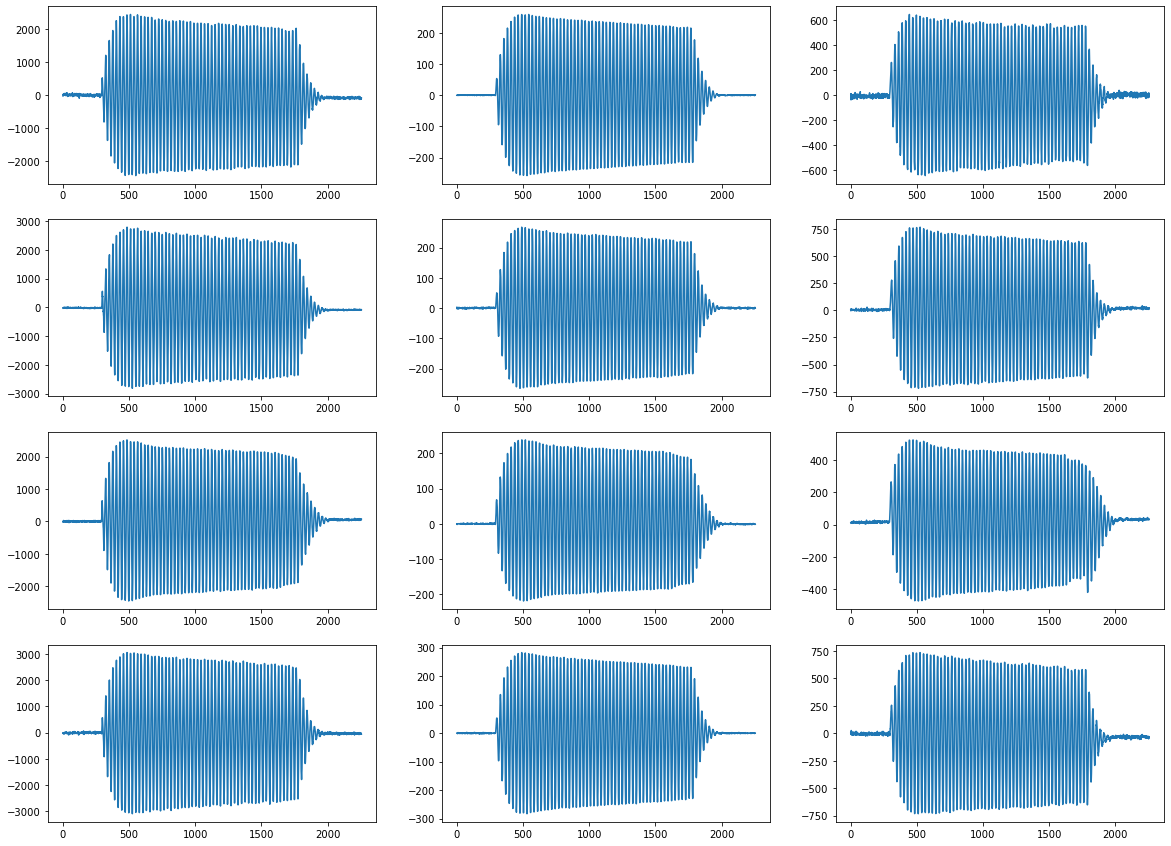

In [7]:
plt.figure(figsize = (20,15))

for i in range(12):
    plt.subplot(4,3,i+1)
    plt.plot(trajectory_list[2][:,i])
    
    
xout_train = trajectory_list[2][1772::,:]
tout_train = experiment_time[1772::].reshape(len(experiment_time[1772::]))

print(np.shape(xout_train.T))

## Great idea from Chris: what if we take the very end of the vacuum shot in which it sort of appears that the circuits were hit by an impulse and are now decaying

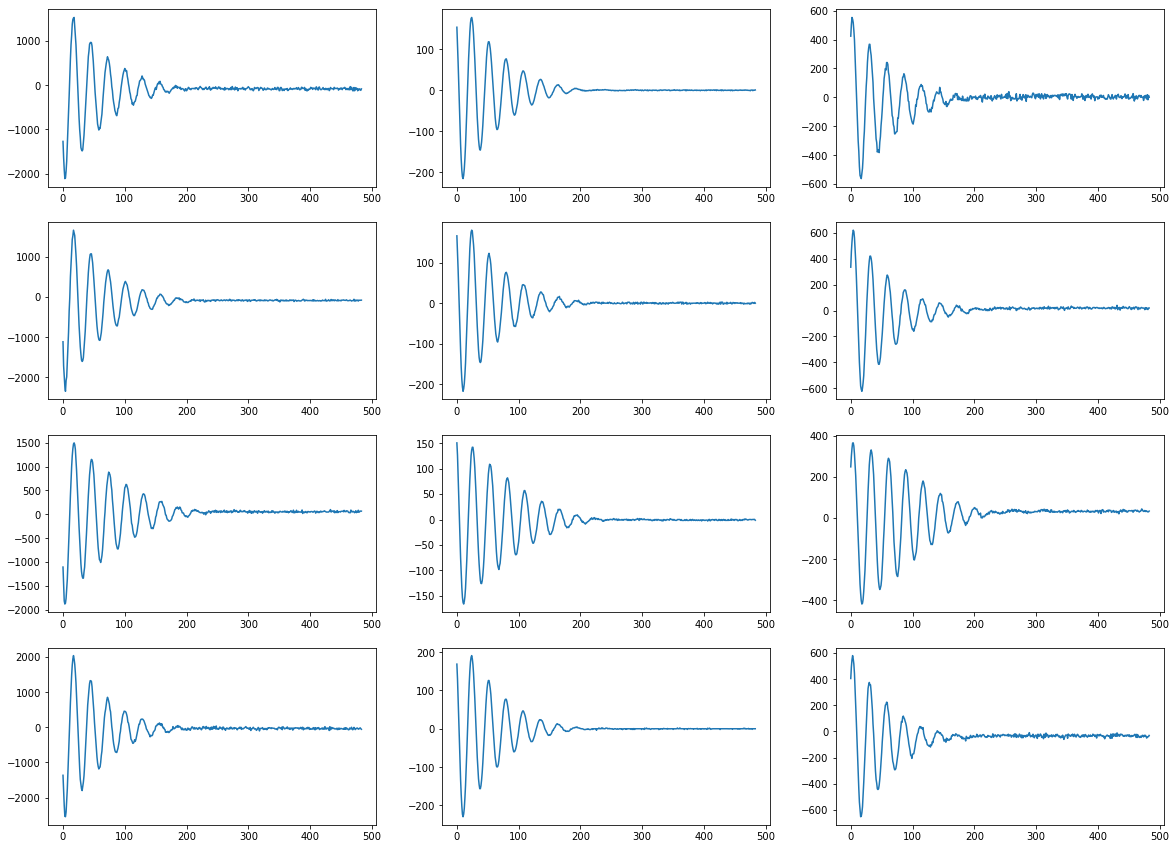

In [8]:
plt.figure(figsize = (20,15))
for i in range(12):
    plt.subplot(4,3,i+1)
    plt.plot(xout_train[:,i])

## No complex conjugate or stability enforcement in this one

In [9]:
np.shape(tout_train)


xout_list = []
Atilde_list = []
bop_list = []



for i in range(12):

    [Atilde,bop_obj,xout] = bopdmd_train_test(
        svd_rank  = i+1,
        num_trials = 20,
        training_set = xout_train.T, #this is the 'impulse' response from above
        training_voltage = np.zeros(np.shape(inputs_list[2])),
        test_voltage = inputs_list[2][251::,:],
        train_time = tout_train,
        test_time = experiment_time[251::], #251 is where the time vector is = 0. Before this the times are negative
        Btilde = B,
        C = C,
        D = D,
        return_training_fit = False,
        conjugate_bool = False, stable_bool = False,
        noise_level = 0,
        evaluate = True)
    xout_list.append(xout)
    Atilde_list.append(Atilde)
    bop_list.append(bop_obj)

C:\Users\ducks\anaconda3\lib\site-packages\pydmd\bopdmd.py:613: RuntimeWarning: overflow encountered in square
  b = np.sqrt(np.sum(np.abs(w) ** 2, axis=0))
C:\Users\ducks\anaconda3\lib\site-packages\pydmd\bopdmd.py:718: RuntimeWarning: invalid value encountered in true_divide
  b_mu = b_sum / self._num_trials
C:\Users\ducks\anaconda3\lib\site-packages\pydmd\bopdmd.py:721: RuntimeWarning: invalid value encountered in true_divide
  b_std = np.sqrt(np.abs(b_sum2 / self._num_trials - np.abs(b_mu) ** 2))
C:\Users\ducks\anaconda3\lib\site-packages\pydmd\bopdmd.py:721: RuntimeWarning: invalid value encountered in subtract
  b_std = np.sqrt(np.abs(b_sum2 / self._num_trials - np.abs(b_mu) ** 2))
C:\Users\ducks\anaconda3\lib\site-packages\pydmd\bopdmd.py:287: RuntimeWarning: overflow encountered in exp
  return np.exp(np.outer(t, alpha))


LinAlgError: SVD did not converge in Linear Least Squares

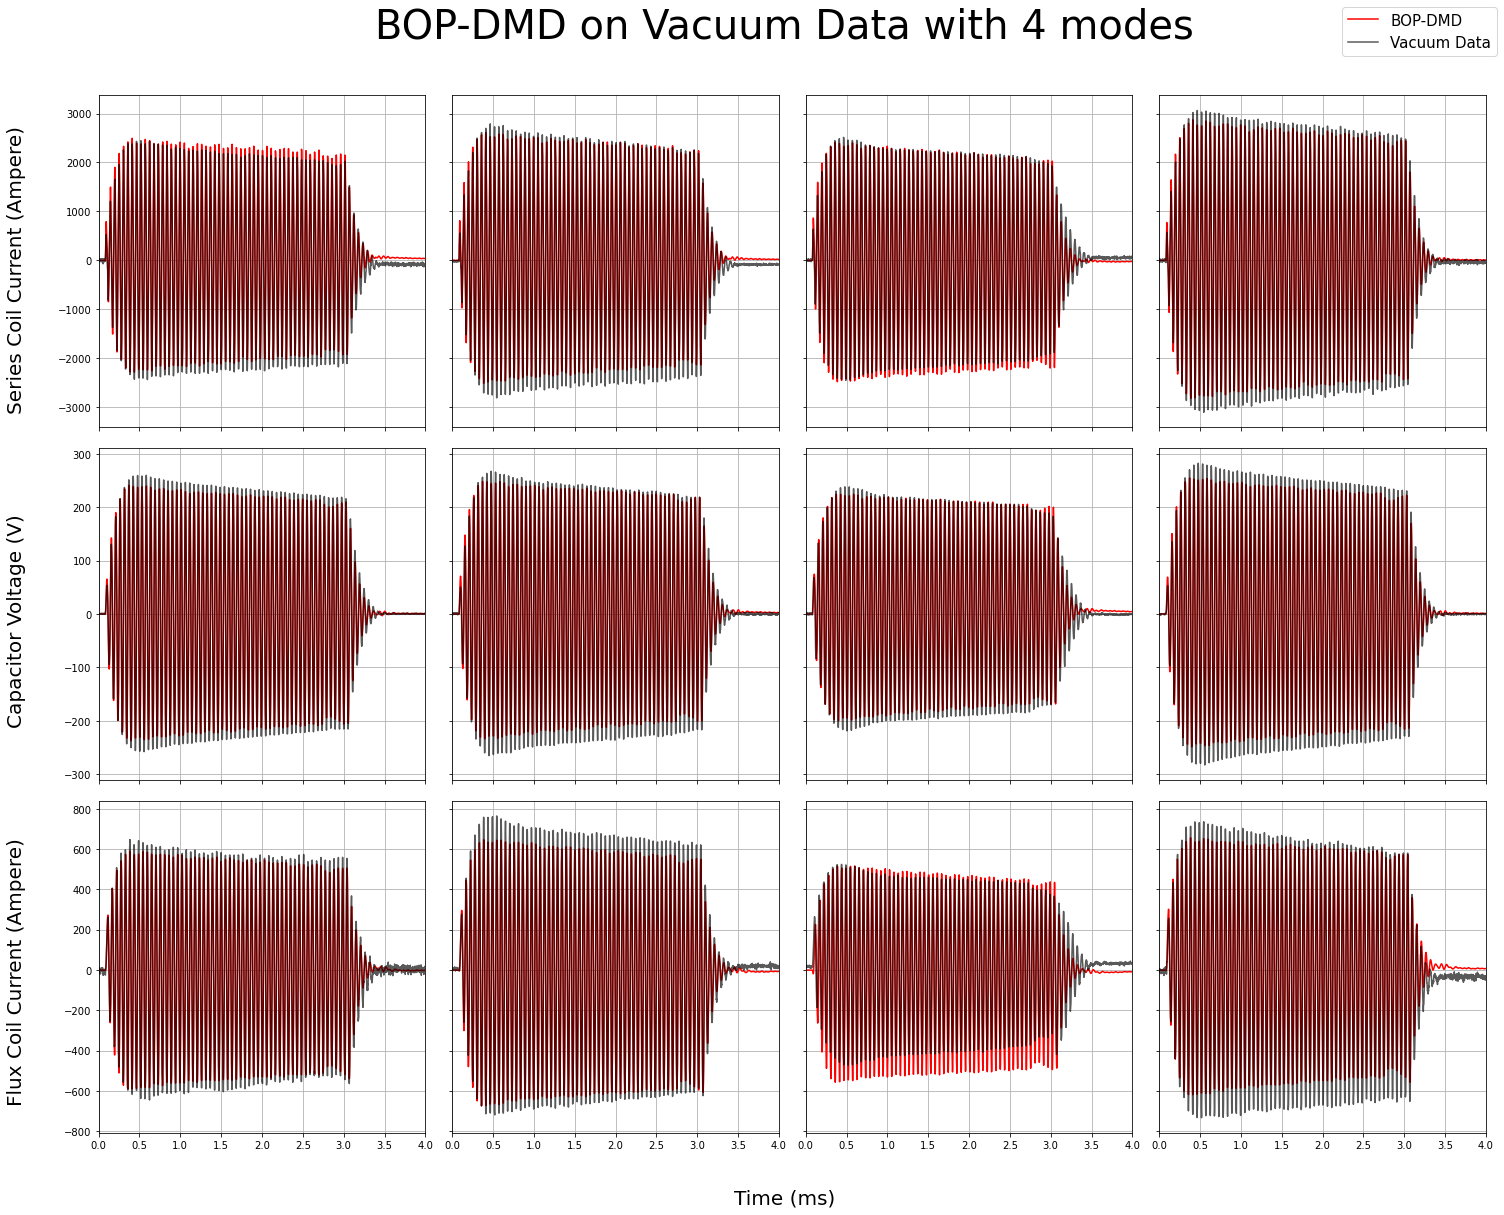

In [10]:
make_graph([np.real(xout_list[4]),trajectory_list[2][251::,:]],'BOP-DMD on Vacuum Data with 4 modes',
           ['BOP-DMD','Vacuum Data'],impulse = False,time = experiment_time[251::])

## Just stable eigs in this one

In [11]:
np.shape(tout_train)


xout_list = []
Atilde_list = []
bop_list = []



for i in range(12):

    [Atilde,bop_obj,xout] = bopdmd_train_test(
        svd_rank  = i+1,
        num_trials = 20,
        training_set = xout_train.T, #this is the 'impulse' response from above
        training_voltage = np.zeros(np.shape(inputs_list[2])),
        test_voltage = inputs_list[2][251::,:],
        train_time = tout_train,
        test_time = experiment_time[251::], #251 is where the time vector is = 0. Before this the times are negative
        Btilde = B,
        C = C,
        D = D,
        return_training_fit = False,
        conjugate_bool = False, stable_bool = True,
        noise_level = 0,
        evaluate = True)
    xout_list.append(xout)
    Atilde_list.append(Atilde)
    bop_list.append(bop_obj)

C:\Users\ducks\anaconda3\lib\site-packages\pydmd\bopdmd.py:613: RuntimeWarning: overflow encountered in square
  b = np.sqrt(np.sum(np.abs(w) ** 2, axis=0))
C:\Users\ducks\anaconda3\lib\site-packages\pydmd\bopdmd.py:718: RuntimeWarning: invalid value encountered in true_divide
  b_mu = b_sum / self._num_trials
C:\Users\ducks\anaconda3\lib\site-packages\pydmd\bopdmd.py:721: RuntimeWarning: invalid value encountered in true_divide
  b_std = np.sqrt(np.abs(b_sum2 / self._num_trials - np.abs(b_mu) ** 2))
C:\Users\ducks\anaconda3\lib\site-packages\pydmd\bopdmd.py:721: RuntimeWarning: invalid value encountered in subtract
  b_std = np.sqrt(np.abs(b_sum2 / self._num_trials - np.abs(b_mu) ** 2))


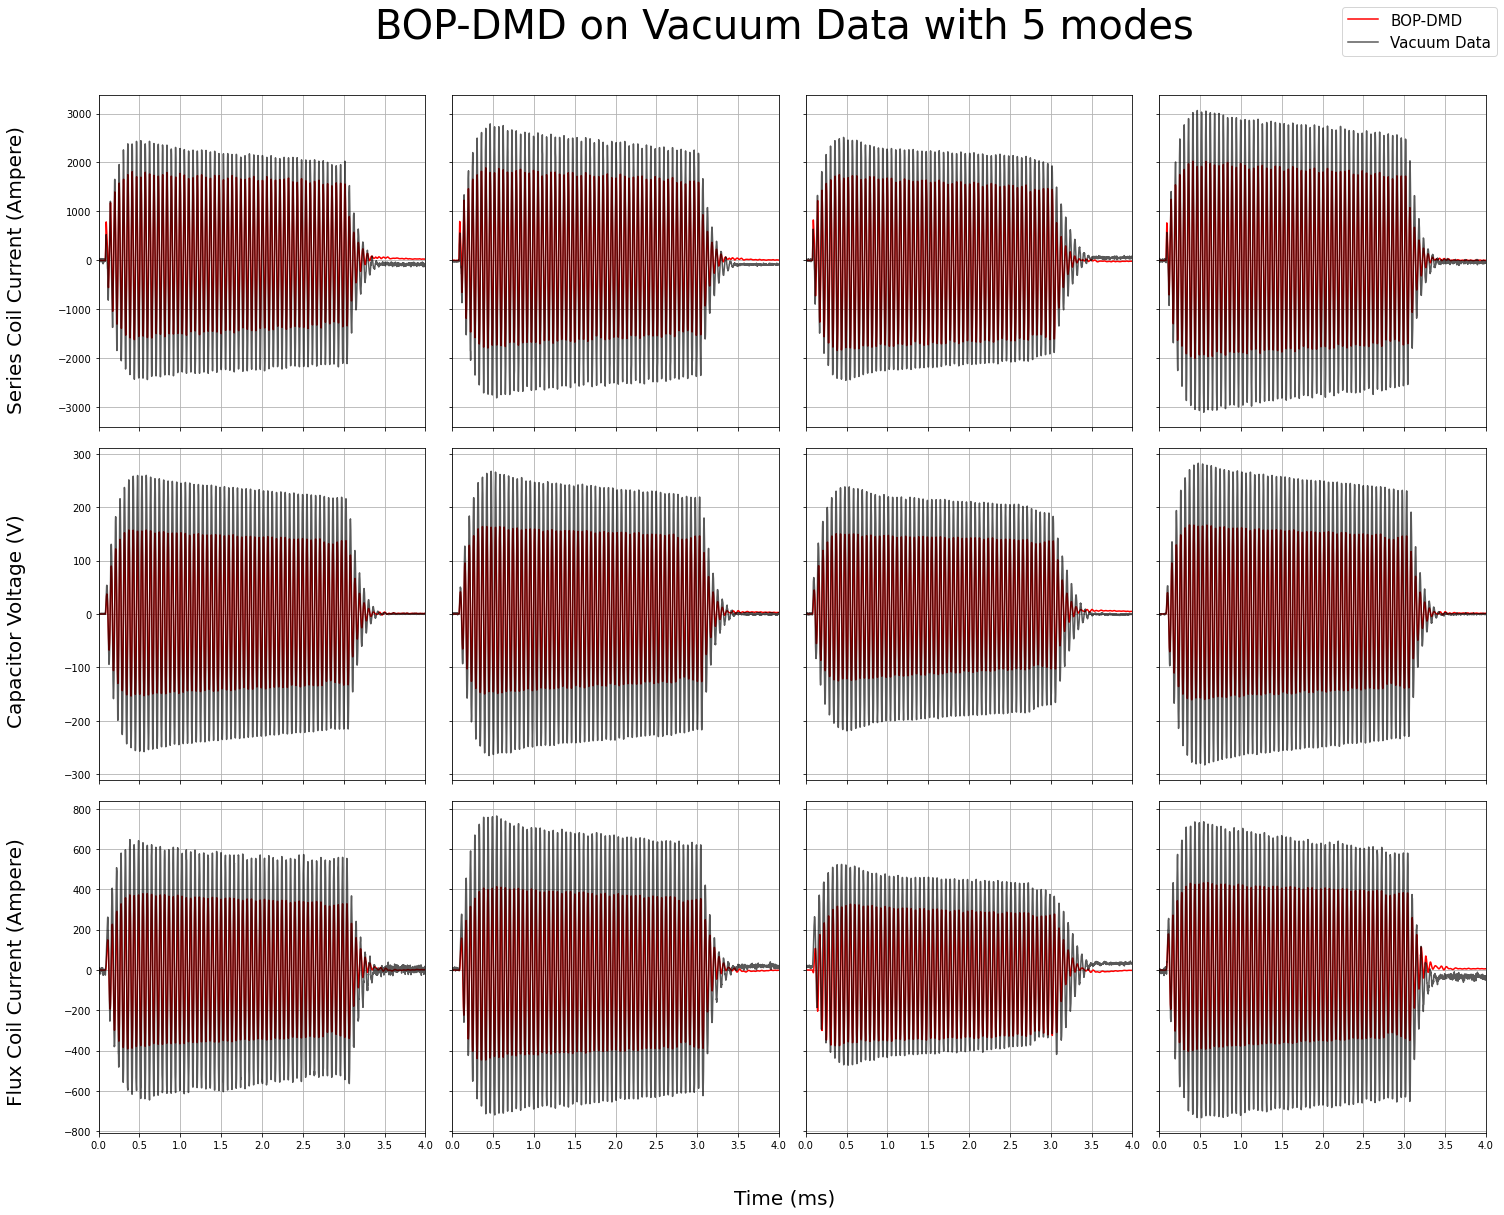

In [12]:
make_graph([np.real(xout_list[4]),trajectory_list[2][251::,:]],'BOP-DMD on Vacuum Data with 5 modes',
           ['BOP-DMD','Vacuum Data'],impulse = False,time = experiment_time[251::])

## Complex conjugate and stable does the best

In [13]:
np.shape(tout_train)


xout_list = []
Atilde_list = []
bop_list = []


for i in range(12):

    [Atilde,bop_obj,xout] = bopdmd_train_test(
        svd_rank  = i+1,
        num_trials = 20,
        training_set = xout_train.T, #this is the 'impulse' response from above
        training_voltage = np.zeros(np.shape(inputs_list[2])),
        test_voltage = inputs_list[2][251::,:],
        train_time = tout_train,
        test_time = experiment_time[251::], #251 is where the time vector is = 0. Before this the times are negative
        Btilde = B,
        C = C,
        D = D,
        return_training_fit = False,
        conjugate_bool = True, stable_bool = True,
        noise_level = 0,
        evaluate = True)
    xout_list.append(xout)
    Atilde_list.append(Atilde)
    bop_list.append(bop_obj)

C:\Users\ducks\anaconda3\lib\site-packages\pydmd\bopdmd.py:613: RuntimeWarning: overflow encountered in square
  b = np.sqrt(np.sum(np.abs(w) ** 2, axis=0))
C:\Users\ducks\anaconda3\lib\site-packages\pydmd\bopdmd.py:270: ComplexWarning: Casting complex values to real discards the imaginary part
  eigenvalues[right_half] = 1j * eigenvalues[right_half].imag
C:\Users\ducks\anaconda3\lib\site-packages\pydmd\bopdmd.py:718: RuntimeWarning: invalid value encountered in true_divide
  b_mu = b_sum / self._num_trials
C:\Users\ducks\anaconda3\lib\site-packages\pydmd\bopdmd.py:721: RuntimeWarning: invalid value encountered in true_divide
  b_std = np.sqrt(np.abs(b_sum2 / self._num_trials - np.abs(b_mu) ** 2))
C:\Users\ducks\anaconda3\lib\site-packages\pydmd\bopdmd.py:721: RuntimeWarning: invalid value encountered in subtract
  b_std = np.sqrt(np.abs(b_sum2 / self._num_trials - np.abs(b_mu) ** 2))


In [14]:
print(np.shape(xout_list[0]))

(2005, 12)


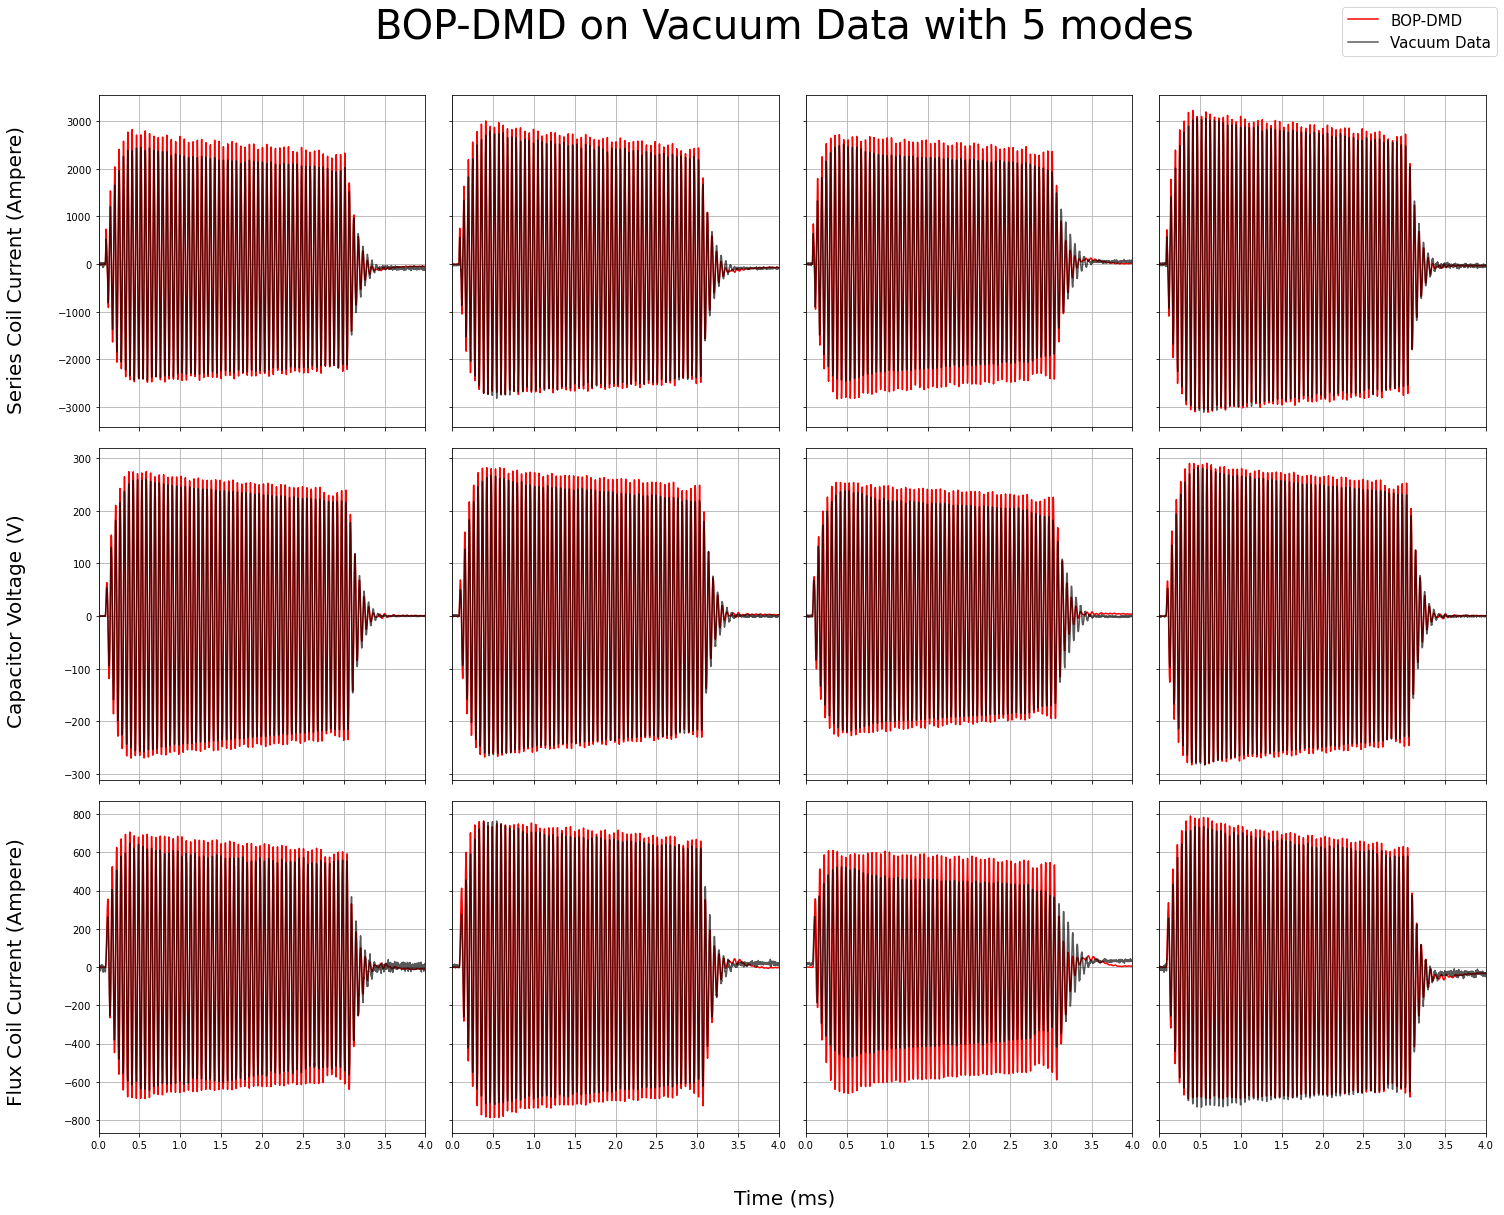

In [15]:
make_graph([np.real(xout_list[4]),trajectory_list[2][251::,:]],'BOP-DMD on Vacuum Data with 5 modes',
           ['BOP-DMD','Vacuum Data'],impulse = False,time = experiment_time[251::])

## This model applies well to other vacuum shots


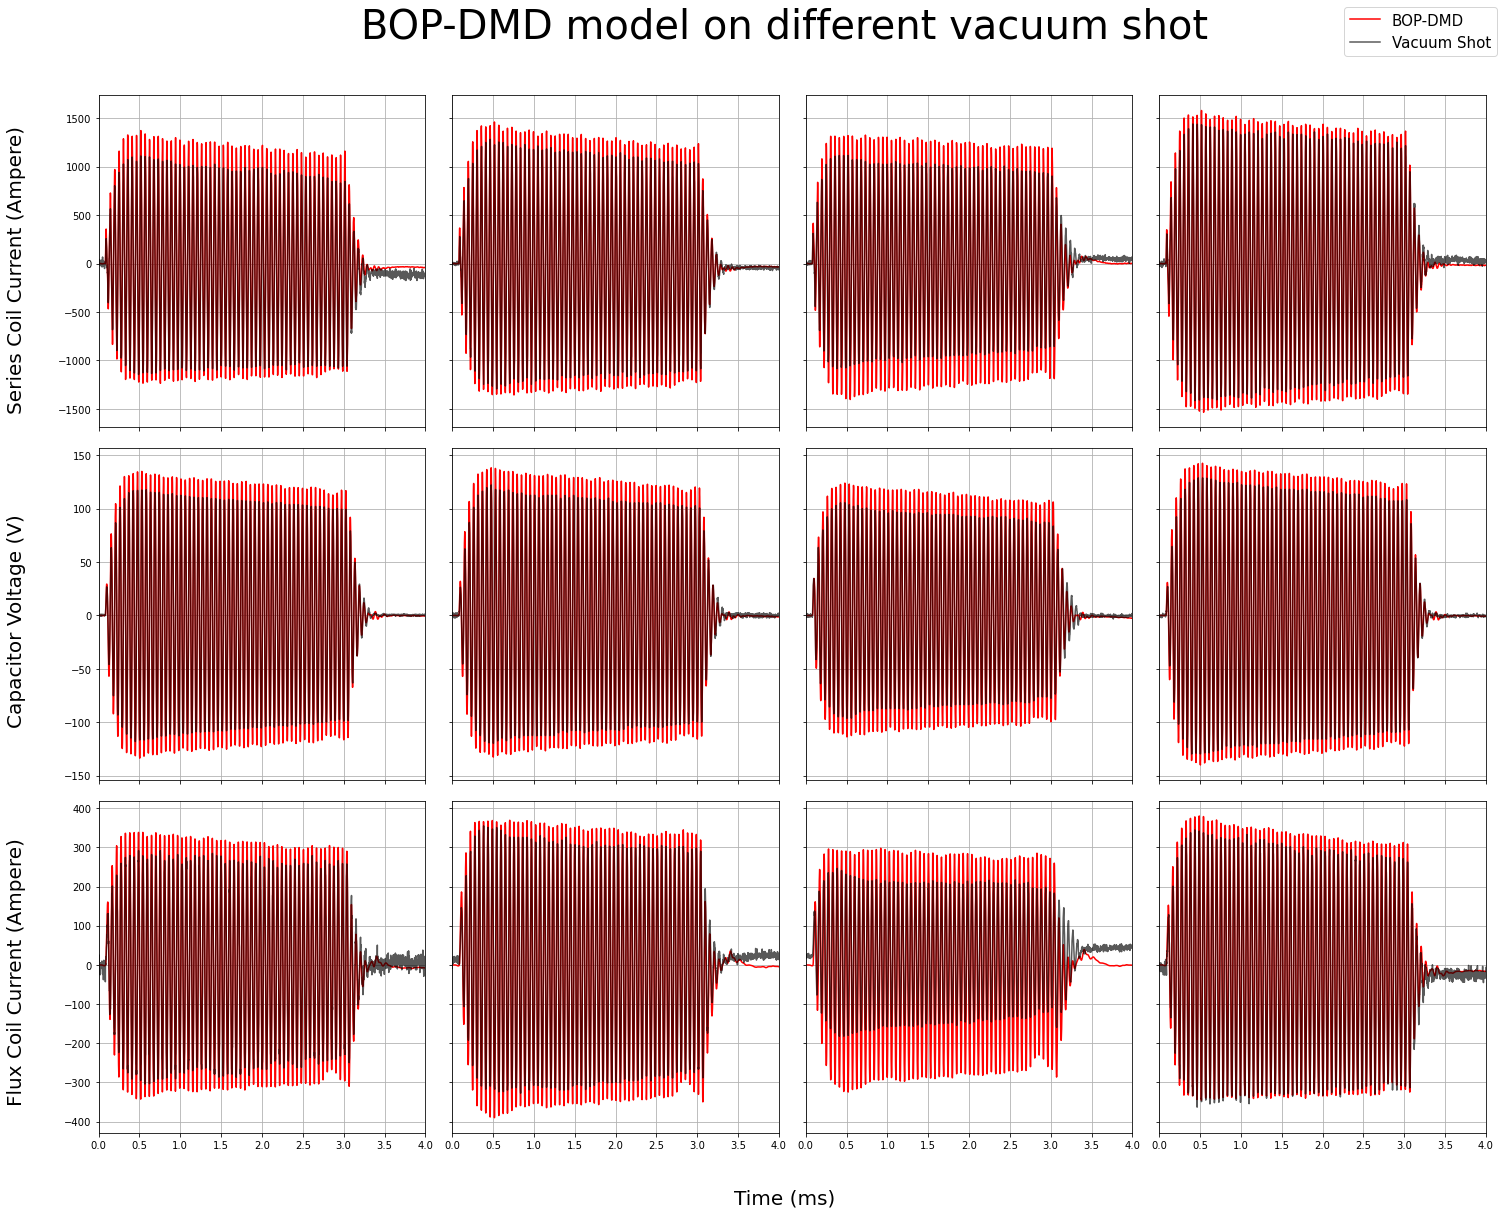

In [16]:
tout,yout,xout = lsim((Atilde_list[4],B,C,D),inputs_list[1][251::,:],experiment_time[251::])
    
make_graph([xout.real,trajectory_list[1][251::,:]],'BOP-DMD model on different vacuum shot',['BOP-DMD','Vacuum Shot'],
           impulse = False, time = experiment_time[251::])

## Leave commented out unless you want a different bop A matrix for other notebooks

In [18]:
# bop_dict = {'matrix':Atilde_list[4],'label': 'BOP'}

# dmd_A = savemat('BOP_A_matrix.mat',bop_dict)

print(Atilde_list[4][0,0])

(63330.051977150026+4.947638389095999j)


## Comparison to SINDy

In [19]:
u = inputs_list[2]
sindy_library = ps.PolynomialLibrary(degree=1, include_bias=False)
optimizer_stable = ps.StableLinearSR3(
    threshold=0.0,
    thresholder='l1',
    nu=1e-7,
    max_iter=10000,
    tol=1e-5,
    verbose=True
#     ensemble = True
)

model = ps.SINDy(feature_library=sindy_library, optimizer=optimizer_stable)
model.fit(trajectory_list[2][1772::,:] , t=experiment_time[1772::], u=u[1772::,::])

 Iteration ... |y - Xw|^2 ...  |w-u|^2/v ...       R(u) ... Total Error: |y - Xw|^2 + |w - u|^2 / v + R(u)
         0 ... 6.1176e+20 ... 8.4565e+19 ... 0.0000e+00 ... 6.1176e+20
      1000 ... 4.7657e+19 ... 2.0207e+18 ... 0.0000e+00 ... 4.7657e+19
      2000 ... 4.7656e+19 ... 2.0133e+18 ... 0.0000e+00 ... 4.7656e+19
      3000 ... 4.7656e+19 ... 2.0130e+18 ... 0.0000e+00 ... 4.7656e+19
      4000 ... 4.7656e+19 ... 2.0130e+18 ... 0.0000e+00 ... 4.7656e+19
      5000 ... 4.7656e+19 ... 2.0129e+18 ... 0.0000e+00 ... 4.7656e+19
      6000 ... 4.7656e+19 ... 2.0129e+18 ... 0.0000e+00 ... 4.7656e+19
      7000 ... 4.7656e+19 ... 2.0129e+18 ... 0.0000e+00 ... 4.7656e+19
      8000 ... 4.7656e+19 ... 2.0129e+18 ... 0.0000e+00 ... 4.7656e+19
      9000 ... 4.7656e+19 ... 2.0129e+18 ... 0.0000e+00 ... 4.7656e+19


C:\Users\ducks\pysindy\pysindy\optimizers\stable_linear_sr3.py:431: ConvergenceWarning: StableLinearSR3._reduce did not converge after 10000 iterations.
  warnings.warn(


SINDy(differentiation_method=FiniteDifference(),
      feature_library=PolynomialLibrary(degree=1, include_bias=False),
      feature_names=['x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9',
                     'x10', 'x11', 'u0', 'u1', 'u2', 'u3'],
      optimizer=StableLinearSR3(max_iter=10000, nu=1e-07, threshold=0.0,
                                verbose=True))

In [20]:
Xi = model.coefficients()
r = Xi.shape[0]
B_SINDy = Xi[:r, r:]
A_SINDy = Xi[:r, :r]

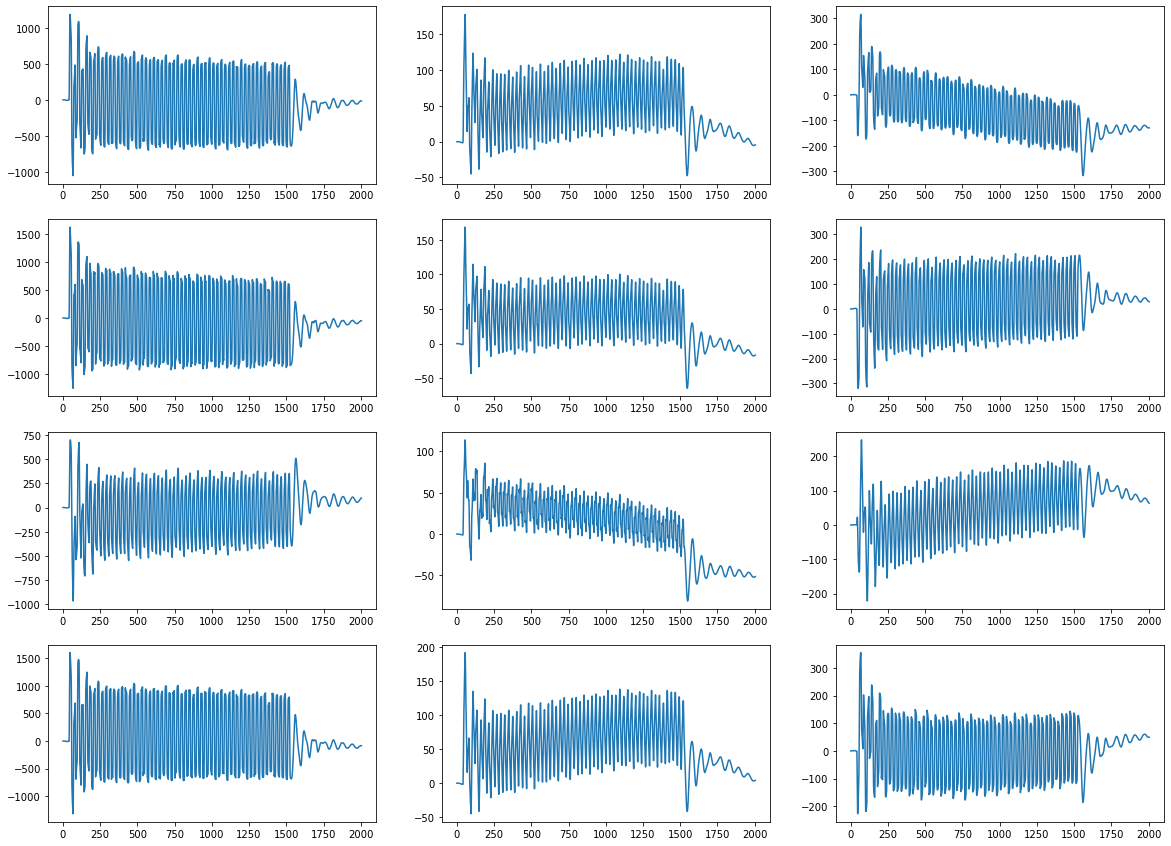

In [21]:
tout,yout,xout_sindy = lsim((A_SINDy,B_SINDy,C,D),inputs_list[2][251::,:],experiment_time[251::])

plt.figure(figsize = (20,15))
for i in range(12):
    plt.subplot(4,3,i+1)
    plt.plot(xout_sindy[:,i])

## All of the cells below this are examining how DMD can reconstruct the measured plasma current as a linear combination of the injector circuit waveforms

In [22]:
def load_plasma_shot(directory): #Pass in a directory as a string, and this function will cycle through the whole directory 
                                 #One important change is that for a plasma shot we will look at the voltage, not the flux circuits
#     directory = "data/vacuum_shots_220816/good_shots"
    data_list = []
    for i in os.listdir(directory):
        if 'mat' in i:
            data_list.append(loadmat(f"{directory}/{i}"))

    # data_list.append(loadmat('data/vacuum_shots_220705_220707/220707001'))
    input_list = []
    state_list = []

    experiment_time = data_list[0].get('time')    
    experiment_time = experiment_time.reshape(len(experiment_time)) #reshape the time vector to a 0d array


#     data = loadmat('data/shot_220816005_data.mat')
#     vals = data['shot_220816005']
#     vals = vals[:,:]

#     voltage1 = vals[:,1]
#     voltage2 = vals[:,2]
#     voltage3 = vals[:,3]
#     voltage4 = vals[:,4]

    trajectory_list = []
    inputs_list = []
    state_deriv_list = []

    state_order = ['i_L1_1','v_cap_1','i_vcoil_1','i_L1_2','v_cap_2','i_vcoil_2','i_L1_3','v_cap_3','i_vcoil_3','i_L1_4','v_cap_4','i_vcoil_4','i_tor']
    state_deriv_order = ['v_L1_1','i_cap_1','v_vcoil_1','v_L1_2','i_cap_2','v_vcoil_2','v_L1_3','i_cap_3','v_vcoil_3','v_L1_4','i_cap_4','v_vcoil_4']
    inputs_order = ['v_spa_1','v_spa_2','v_spa_3','v_spa_4']

    state_dict = dict.fromkeys(state_order)
    state_deriv_dict = dict.fromkeys(state_deriv_order)
    inputs_dict = dict.fromkeys(inputs_order)

    for d in data_list:

        for k,v in d.items():
            if k in state_dict:
                state_dict[k] = v
            if k in state_deriv_dict:
                state_deriv_dict[k] = v
            if k in inputs_dict:
                inputs_dict[k] = v


        trajectory_list.append(np.asarray(list(state_dict.values())).T)
        inputs_list.append(np.asarray(list((inputs_dict.values()))).T)
        state_deriv_list.append((np.asarray(list(state_deriv_dict.values())).T))



    for i in range(len(trajectory_list)):
        trajectory_list[i] = trajectory_list[i][0,:,:]
        inputs_list[i] = inputs_list[i][0,:,:]
        state_deriv_list[i] = state_deriv_list[i][0,:,:]

    return trajectory_list,inputs_list,state_deriv_list




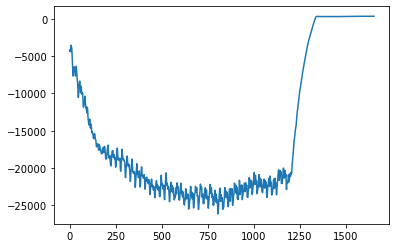

In [23]:
directory = 'data/plasma_shots/220816009'

voltage_trajectory_list,voltage_inputs_list,voltage_state_deriv_list = load_plasma_shot(directory)


#Ayyy we got a plasma current
plt.plot(voltage_trajectory_list[0][600::,12])



## The cell below removes some weird artifacts from the experimental data

[-3.64192854]


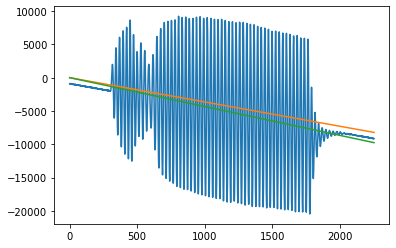

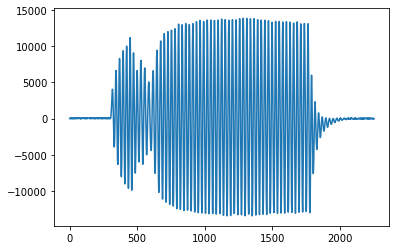

In [26]:



vcoil_3 = voltage_trajectory_list[0][:,8].reshape(len(voltage_trajectory_list[0][0::,8]),1)

linear_fit = (vcoil_3[-1] - vcoil_3[0])/(len(vcoil_3))

print((linear_fit))

plt.plot(vcoil_3)
plt.plot(linear_fit*np.arange(len(vcoil_3)))

n = np.arange(len(vcoil_3)).reshape(len(vcoil_3),1)

lstsq_fit = np.linalg.pinv(n)@vcoil_3

plt.plot(lstsq_fit*n)

plt.figure()
plt.plot((vcoil_3 - (linear_fit*n))-vcoil_3[0])

#Linear fit looks good, and we subtracted off the offset

voltage_trajectory_list[0][:,8] = ((vcoil_3 - (linear_fit*n))-vcoil_3[0]).reshape(len(vcoil_3))

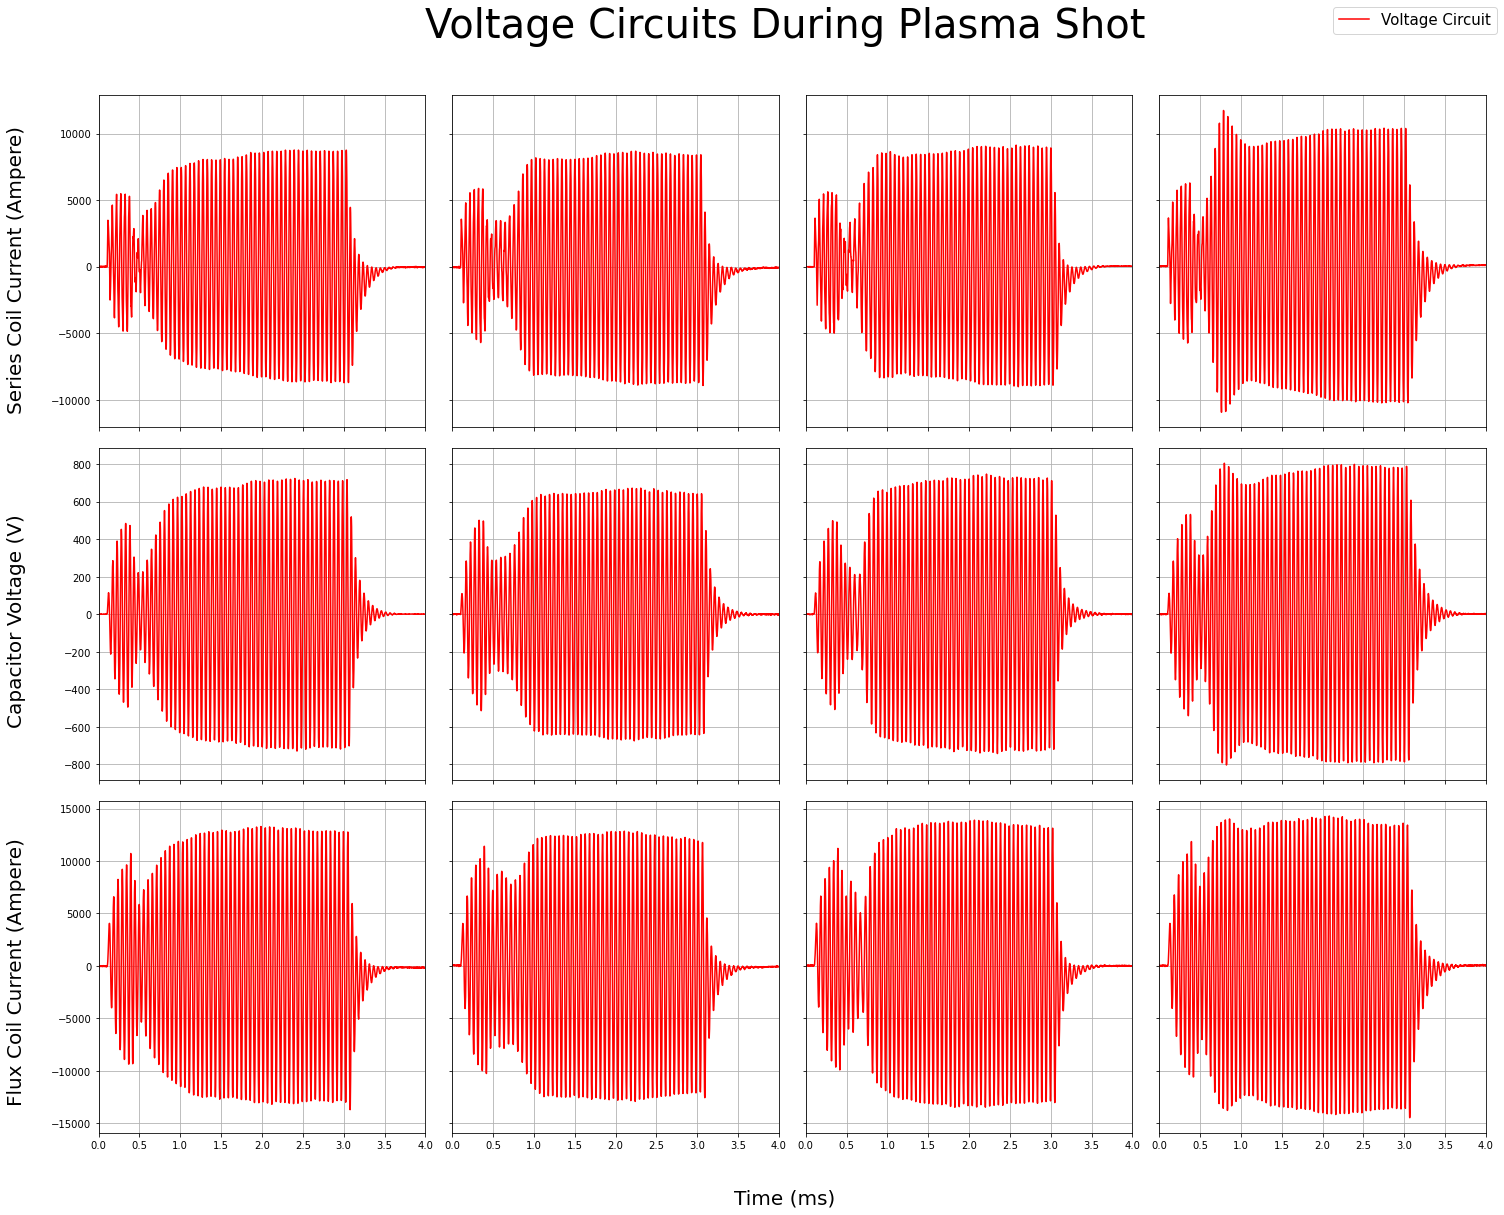

In [27]:
# plt.figure(figsize = (20,15))
# for i in range(12):
#     plt.subplot(4,3,i+1)
#     plt.plot(experiment_time,voltage_trajectory_list[0][:,i])
# plt.figure()
# # plt.plot(plasma_trajectory_list[0][1500:1800,12])

make_graph([voltage_trajectory_list[0][251::,:]],'Voltage Circuits During Plasma Shot',['Voltage Circuit'],impulse = False,
          time = experiment_time[251::])

## So this is pretty interesting: when I train on the plasma portion of the shot (500 snapshots in the middle), and then I see when BOP does best, it actually looks like it's at 12 modes. => That the plasma current is linearly dependent on the injector currents and voltages => it can be well modeled by only looking at the injector dynamics. 

(2256, 12)


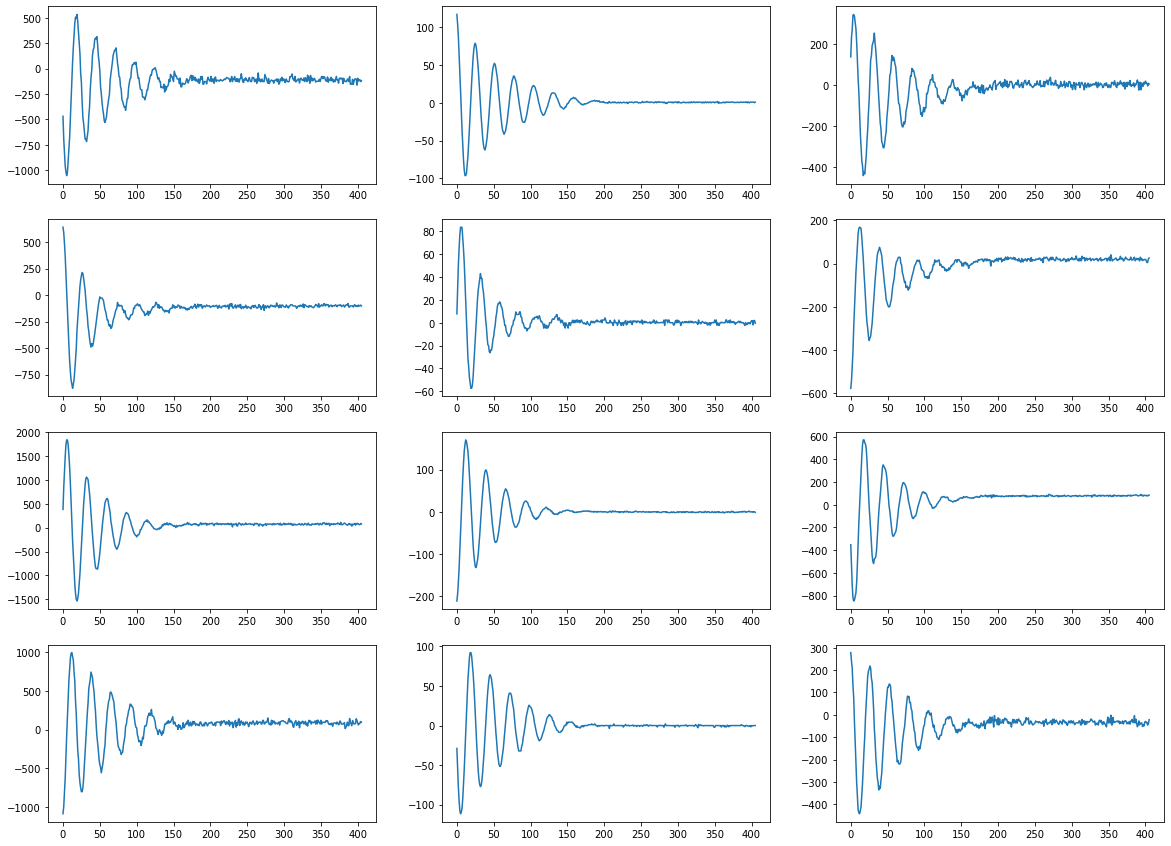

In [28]:
flux_plasma_trajectory_list,flux_plasma_inputs_list,flux_plamsa_state_deriv_list,flux_plasma_experiment_time = load_vacuum_shot(directory='data/plasma_shots/flux_data/220816009')

print(np.shape(flux_plasma_trajectory_list[0]))

plt.figure(figsize = (20,15))
for i in range(12):
    plt.subplot(4,3,i+1)
    plt.plot(flux_plasma_trajectory_list[0][1850::,i])

In [29]:
full_injector_list = []
full_injector_list.append( np.hstack((flux_plasma_trajectory_list[0],voltage_trajectory_list[0])) )

full_inputs_list = []
full_inputs_list.append( np.hstack((flux_plasma_inputs_list[0],voltage_inputs_list[0])) )

print(np.shape(full_injector_list[0]))
print(np.shape(full_inputs_list[0]))

# plt.plot(full_injector_list[0][:,23])

(2256, 25)
(2256, 8)


## So now I've stacked together the flux, and voltage circuits and I'm going to try DMD on the ring down of the shot, and on the plasma portion in the middle.

In [30]:
Atilde_injector_list = []
bop_injector_obj_list = []
for i in range(30):
    [Atilde,bop_obj] = bopdmd_train_test(
        svd_rank  = i+1,
        num_trials = 20,
        training_set = full_injector_list[0].T[:,700:1850], #np.vstack( (full_injector_list[0].T[0:25,700:1850],recon_signal[700:1850]) ), #this is the 'impulse' response from above
        training_voltage = np.zeros(np.shape(inputs_list[2])),
        test_voltage = full_inputs_list[0][700:1850,:],
        train_time = experiment_time[700:1850],
        test_time = experiment_time[700:1850], #251 is where the time vector is = 0. Before this the times are negative
        Btilde = B,
        C = C,
        D = D,
        return_training_fit = False,
        conjugate_bool = True, stable_bool = True,
        noise_level = 0,
        evaluate = False)
    Atilde_injector_list.append(Atilde)
    bop_injector_obj_list.append(bop_obj)

C:\Users\ducks\anaconda3\lib\site-packages\pydmd\bopdmd.py:270: ComplexWarning: Casting complex values to real discards the imaginary part
  eigenvalues[right_half] = 1j * eigenvalues[right_half].imag
C:\Users\ducks\anaconda3\lib\site-packages\pydmd\bopdmd.py:534: RuntimeWarning: divide by zero encountered in true_divide
  improvement_ratio = actual_improvement / pred_improvement


30
(25, 1150)


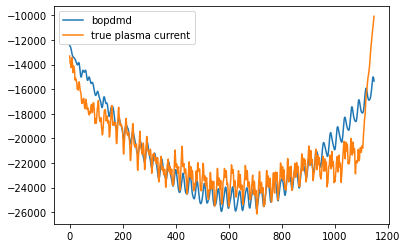

In [31]:
print(len(Atilde_injector_list))

num = 21
bopdmd_injector_states = np.real(bop_injector_obj_list[num].modes@bop_injector_obj_list[num].dynamics)

print(np.shape(bopdmd_injector_states))

# plt.figure(figsize = (20,15))
# for i in range(12):
#     plt.subplot(4,3,i+1)
#     plt.plot(bopdmd_injector_states[i,:])

plt.figure()
plt.plot(bopdmd_injector_states[24,:])
plt.plot(full_injector_list[0][700:1850,24])
plt.legend(['bopdmd','true plasma current'])

In [32]:
#need to modify our B matrix

B_full = np.zeros((25,8))

B_full[0:12,0:4] = B
B_full[12:24,4:8] = B

C_full = np.zeros((8,25))
D_full = np.zeros((8,8))

print(np.shape(full_inputs_list[0][251::,:]))

(2005, 8)
